# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word Embedding</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Model</a></div>

# Load Data

In [8]:
import json
import os

In [9]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [10]:
sentence = load_data('done_data.json', 'sentence')
label = load_data('done_data.json', 'label')

# Word Segmentation

In [11]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)')
re_replace = re.compile(u'([^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.])|（(.*?)）|\((.*?)\)')

In [13]:
filename = "stopwords.txt"
stopWords = [w for w in open(filename).read().split()]

In [14]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub('', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in ws if i not in stopWords]

In [17]:
casualSent = [sentence[i] for i in range(len(sentence)) if label[i] == 1]
sentWords = [del_stop(newcut(s)) for s in casualSent]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/kz/hqjl_dfx3g3_2vxylxlj1s940000gn/T/jieba.cache
Loading model cost 0.983 seconds.
Prefix dict has been built succesfully.


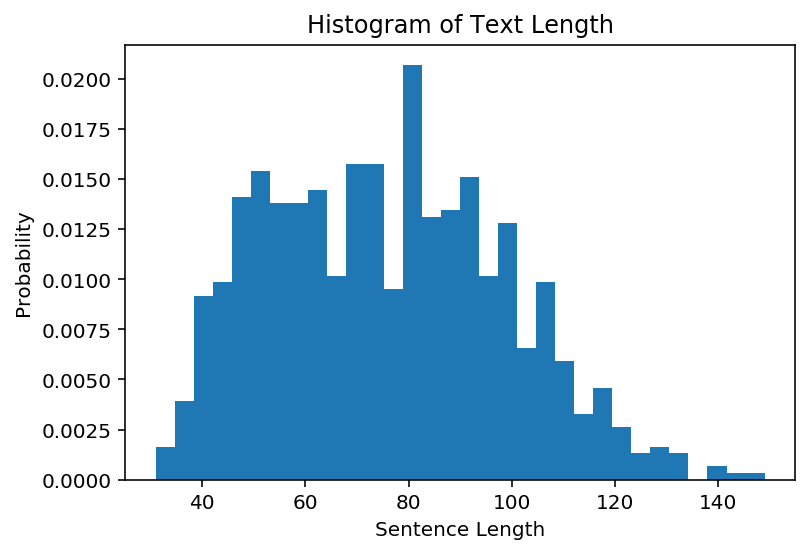

In [18]:
plt.hist([len(i) for i in sentWords], bins=32, normed=True);
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.title('Histogram of Text Length')  

# Tokenize Text

In [19]:
from keras.preprocessing.text import Tokenizer
import numpy as np

In [20]:
tokWords = sentWords.copy()
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
sentLens = np.array([len(i) for i in sentWords])
print('Number of sentences: \t{:d}'.format(len(sentLens)))
print('Distribution of sentence lengths (number of words):')
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))
print('Found %s unique tokens.' % len(word2index))

Number of sentences: 	826
Distribution of sentence lengths (number of words):
Min: 31   Max: 149   Mean: 75.713   Med: 75.000
Found 9449 unique tokens.


In [21]:
MAX_LEN = 150 # Approximately twice the median length of sentences

# Word Embedding

In [22]:
VOCAB_SIZE = 55936
EMBEDDING_SIZE = 256
SEED = 42

# Build Model

In [3]:
MAX_LEN = 150
VOCAB_SIZE = 55936
EMBEDDING_SIZE = 256
LATENT_SIZE = 512
NUM_EPOCHS = 36
BATCH_SIZE = 64
#NUM_TRAIN_STEPS = len(xTrain) // BATCH_SIZE # 222
#NUM_VAL_STEPS = len(xVal) // BATCH_SIZE # 95
NUM_TRAIN_STEPS = 14
NUM_VAL_STEPS = 6

In [1]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, RepeatVector
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [4]:
K.clear_session()
inputs = Input(shape=(MAX_LEN, EMBEDDING_SIZE), name='INPUT') 
encoded = Bidirectional(LSTM(LATENT_SIZE, return_sequences=False, implementation=0), merge_mode='sum', name='ENCODER_BiLSTM')(inputs)
decoded = RepeatVector(MAX_LEN, name="REPEATER")(encoded)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, implementation=0), merge_mode='sum', name='DECODER_BiLSTM')(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(loss='mse', optimizer='rmsprop')

In [7]:
filename = '/Users/lizhn7/Downloads/DATA/chinese_news/sent2vec/cp_logs/weights.033-0.002166.hdf5'
autoencoder.load_weights(filename)

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()